<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/Home_ToursHabitat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install summarytools -q

In [66]:
!pip install pygwalker -q

In [67]:
pip install sweetviz -q

In [68]:
import pygwalker as pyg
from summarytools import dfSummary # module pandas-profiling
import pandas as pd
import sweetviz as sv # Module pour faire le rapport HTML
import missingno as msno

In [69]:
# Charger les fichiers CSV en conservant les titres des colonnes
THabitat2023 = pd.read_csv("/content/Tours Habitat_2023.csv",sep= ";")
THabitat2024= pd.read_csv("/content/Tours Habitat_2024.csv",sep= ";")

In [70]:
my_report = sv.analyze(THabitat2024)

                                             |          | [  0%]   00:00 -> (? left)

In [71]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<Axes: >

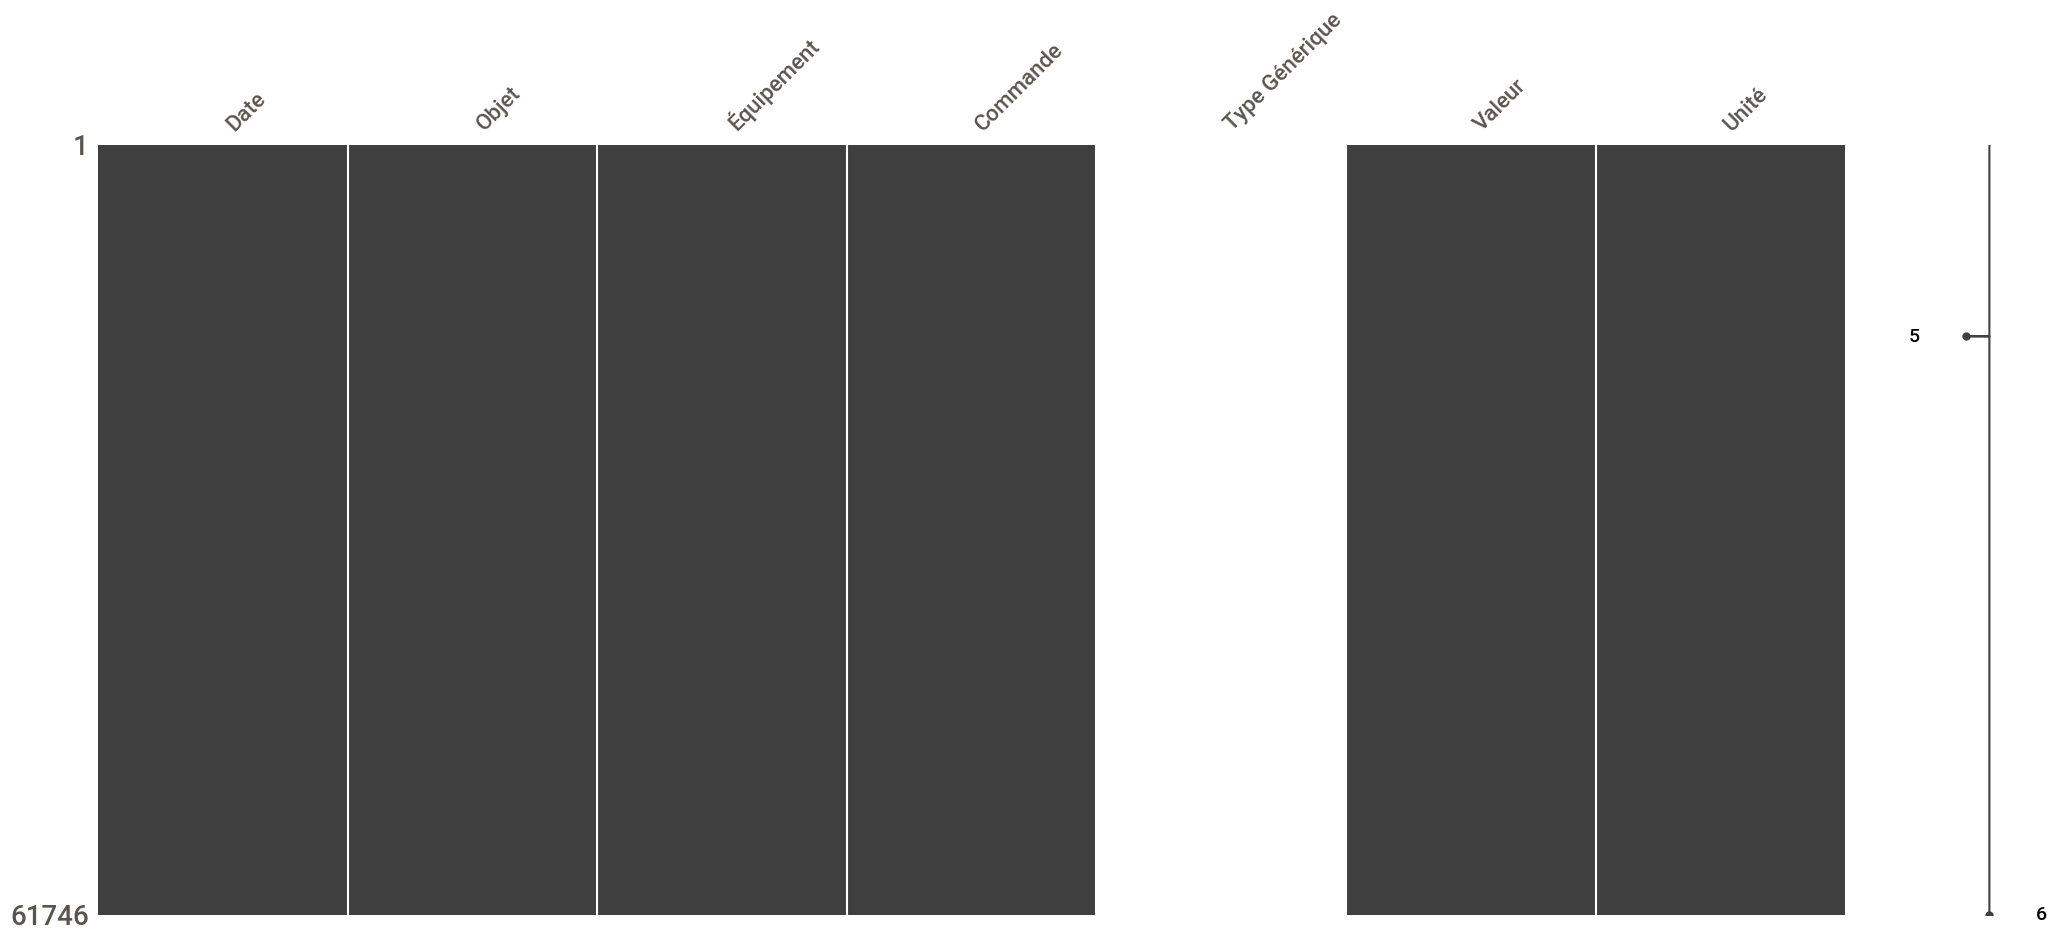

In [72]:
msno.matrix(THabitat2023)

<Axes: >

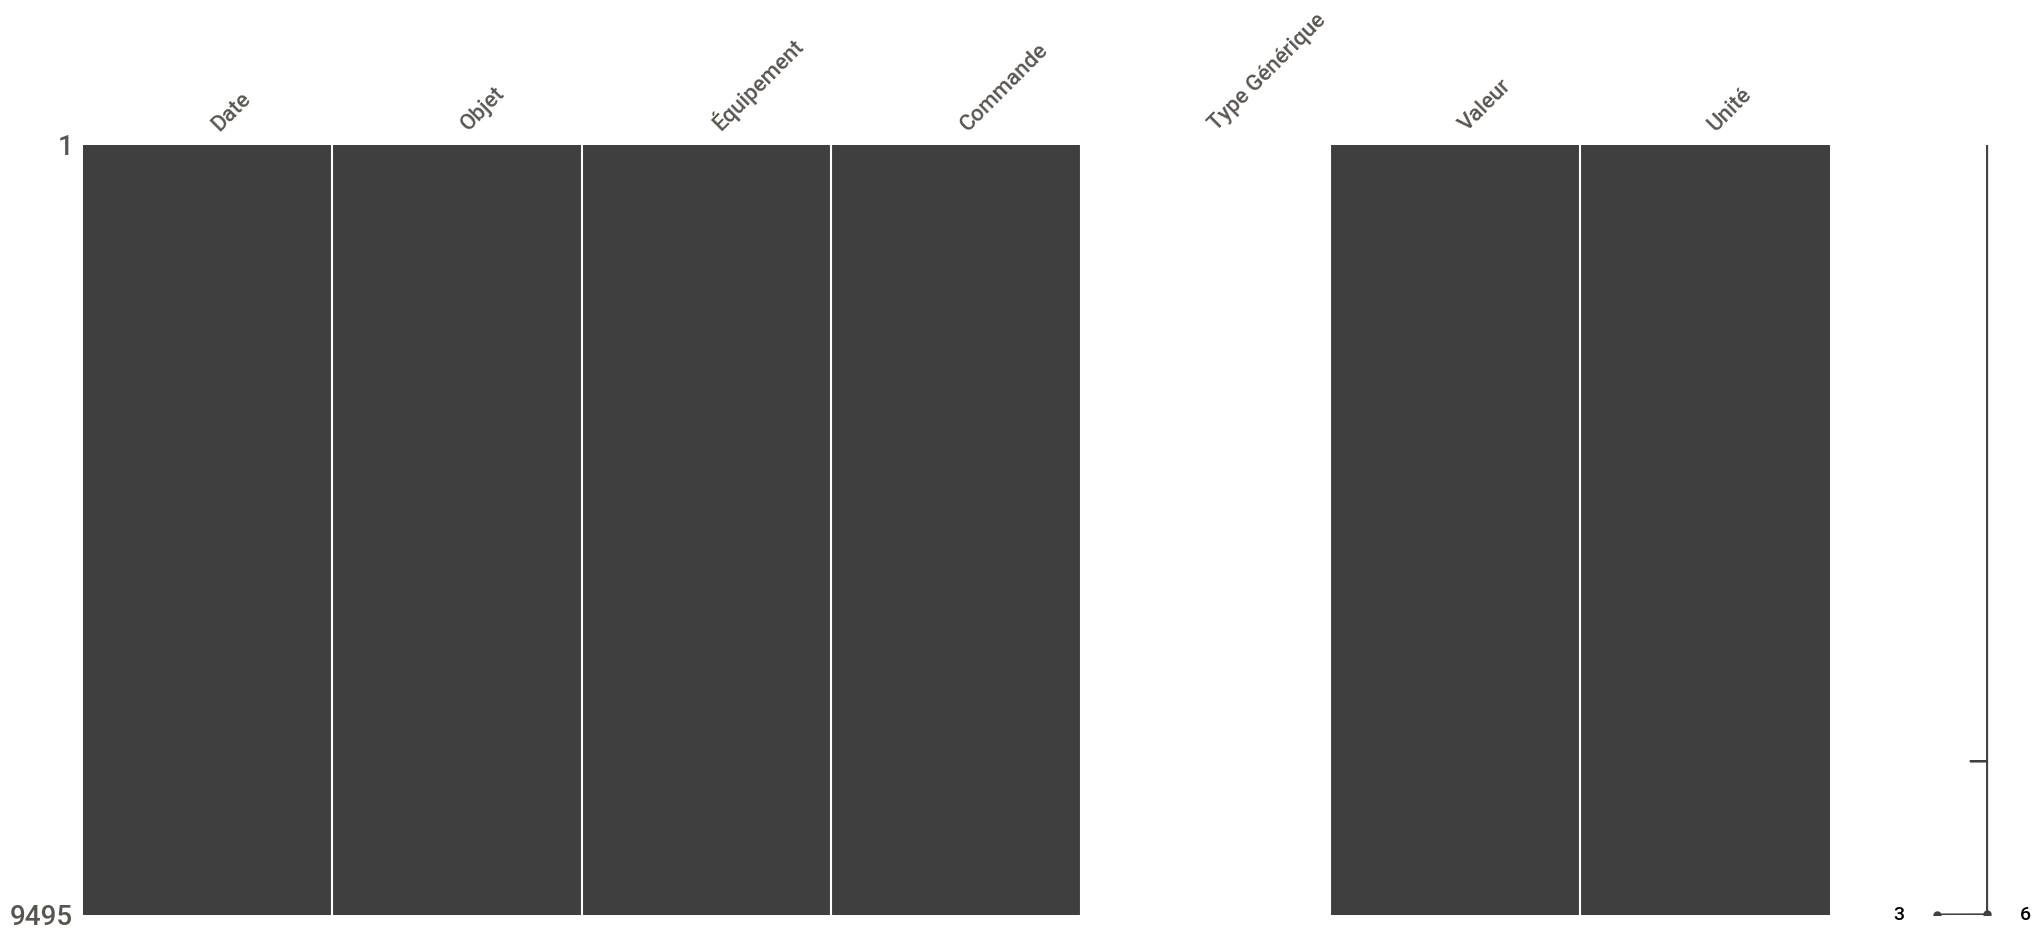

In [73]:
msno.matrix(THabitat2024)

In [74]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(THabitat2024)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-03-13 14:00:062. 2024-01-26 15:00:053. 2024-02-13 16:00:054. 2024-04-10 10:00:055. 2024-01-17 15:00:076. 2024-01-24 16:22:057. 2024-01-24 18:00:068. 2024-04-03 12:00:059. 2024-03-25 18:00:0610. 2024-01-03 11:00:0511. other,"5 (0.1%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)9,454 (99.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Objet[object],1. Données calculées,"9,495 (100.0%)",,0(0.0%)
3,Équipement[object],1. Conso horaire 1er Etage_1204092. Conso horaire E2_120417_FCH3. Conso horaire E2_1204,"7,604 (80.1%)1,890 (19.9%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABi0lEQVR4nO3bwW3CQBgF4bfIIuFiy0KihKQHikixKcJFpAeE2EMguTiH1MD8EszXwK7EADLitXVdIxE21RfQ82hJdkm21RcR5ndd12vFwcN+v/8Yx3GuOFy83vu5tfZZEdwwjuN8PB6v0zTd6MPFulwur8uyzKfTaZuEjy1Jpmm6HQ6Hb/pwldhVHewDgjDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJsyQ/P/Pqfoiur/q13novZ+XZZlT+D8ncXrv5yS/FWe7QXg+ZRuE5pRPlOpPtrJ3mXil66rKpY94Zeuq6qWPeNXrKp+An4g/6gpjbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMKUrauqlz7ila6rKpc+4rlBEMZ1lTA+IAhjbMJsWmvvrTWfDHV3myRvSV6qL6LH59eoMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCbJJ8Jfmpvogen+sqYfwaFeYP50VzOgfKDrMAAAAASUVORK5CYII="">",0(0.0%)
4,Commande[object],1. Conso E1 Tableau général2. Conso E1 Bureaux3. Conso E2 Tableau Général4. Conso E1 Eclairage5. Conso E1 Circulation6. Conso E1 Seche Main F7. Conso E1 Seche Main H8. Conso E2 Coffret9. nan,"2,228 (23.5%)2,009 (21.2%)1,889 (19.9%)1,698 (17.9%)1,395 (14.7%)238 (2.5%)36 (0.4%)1 (0.0%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADi0lEQVR4nO3dzW0bVwBG0TcC4cQbEgQBlZD0oCJcbIpgEelBEMRF7HjDLCIb8s/Scx+hOaeCt7h4Yw7mk5fr9TqgcDf7AGyH2MiIjYzYyIiNjNjIiI3MMsZ4P8Z4N/sgr3y+Xq8fZx+CX293Op0+7Pf74+yDfHG5XJ6WZflLcG/Pbr/fHx8eHj4eDodPsw/z/Pz8+/l8Pj4+Pr4bY4jtjdmNMcbhcPh0f3//z+zDvHg/+wCsww8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mrsx/v+0Z/ZBxridc7CO3eVyeTqfz8dxI5/2XC6XpzHG59nn4NfzWTiZxd/6oHIrN5vbbANuYvBi5LIN0wcvRi7bcSuDl5v4Jcy6vNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjM33wYuSyHTcxeDFy2QafhZMxeCHjBwKZ2Y9Rj88NmbqusqralmnrKquq7Zm9rrKq2hA/EMiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhMW1dZVW3P1HWVVdW2+CycjHUVmRk3m9tso/LBi5HLdqWDFyOXbZsxeDFy2SgvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mikgxcjl23LBy9GLtvls3AyBi9k1r7Z3GJ8tergxbiF11YbvBi38L21By/GLXzlpS4ZsZERGxmxkREbGbGRERsZsZERGxmxk

In [75]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(THabitat2024)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2024-03-13 14:00:062. 2024-01-26 15:00:053. 2024-02-13 16:00:054. 2024-04-10 10:00:055. 2024-01-17 15:00:076. 2024-01-24 16:22:057. 2024-01-24 18:00:068. 2024-04-03 12:00:059. 2024-03-25 18:00:0610. 2024-01-03 11:00:0511. other,"5 (0.1%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)4 (0.0%)9,454 (99.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,Objet[object],1. Données calculées,"9,495 (100.0%)",,0(0.0%)
3,Équipement[object],1. Conso horaire 1er Etage_1204092. Conso horaire E2_120417_FCH3. Conso horaire E2_1204,"7,604 (80.1%)1,890 (19.9%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABi0lEQVR4nO3bwW3CQBgF4bfIIuFiy0KihKQHikixKcJFpAeE2EMguTiH1MD8EszXwK7EADLitXVdIxE21RfQ82hJdkm21RcR5ndd12vFwcN+v/8Yx3GuOFy83vu5tfZZEdwwjuN8PB6v0zTd6MPFulwur8uyzKfTaZuEjy1Jpmm6HQ6Hb/pwldhVHewDgjDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJsyQ/P/Pqfoiur/q13novZ+XZZlT+D8ncXrv5yS/FWe7QXg+ZRuE5pRPlOpPtrJ3mXil66rKpY94Zeuq6qWPeNXrKp+An4g/6gpjbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQljbMKUrauqlz7ila6rKpc+4rlBEMZ1lTA+IAhjbMJsWmvvrTWfDHV3myRvSV6qL6LH59eoMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCbJJ8Jfmpvogen+sqYfwaFeYP50VzOgfKDrMAAAAASUVORK5CYII="">",0(0.0%)
4,Commande[object],1. Conso E1 Tableau général2. Conso E1 Bureaux3. Conso E2 Tableau Général4. Conso E1 Eclairage5. Conso E1 Circulation6. Conso E1 Seche Main F7. Conso E1 Seche Main H8. Conso E2 Coffret9. nan,"2,228 (23.5%)2,009 (21.2%)1,889 (19.9%)1,698 (17.9%)1,395 (14.7%)238 (2.5%)36 (0.4%)1 (0.0%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADi0lEQVR4nO3dzW0bVwBG0TcC4cQbEgQBlZD0oCJcbIpgEelBEMRF7HjDLCIb8s/Scx+hOaeCt7h4Yw7mk5fr9TqgcDf7AGyH2MiIjYzYyIiNjNjIiI3MMsZ4P8Z4N/sgr3y+Xq8fZx+CX293Op0+7Pf74+yDfHG5XJ6WZflLcG/Pbr/fHx8eHj4eDodPsw/z/Pz8+/l8Pj4+Pr4bY4jtjdmNMcbhcPh0f3//z+zDvHg/+wCsww8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mrsx/v+0Z/ZBxridc7CO3eVyeTqfz8dxI5/2XC6XpzHG59nn4NfzWTiZxd/6oHIrN5vbbANuYvBi5LIN0wcvRi7bcSuDl5v4Jcy6vNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjM33wYuSyHTcxeDFy2QafhZMxeCHjBwKZ2Y9Rj88NmbqusqralmnrKquq7Zm9rrKq2hA/EMiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhMW1dZVW3P1HWVVdW2+CycjHUVmRk3m9tso/LBi5HLdqWDFyOXbZsxeDFy2SgvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Mikgxcjl23LBy9GLtvls3AyBi9k1r7Z3GJ8tergxbiF11YbvBi38L21By/GLXzlpS4ZsZERGxmxkREbGbGRERsZsZERGxmxk

- 1 nan dans les Unités -> regarder pour faire des modifications
- 100 % de donnée manquante dans "Type Générique".
- Deux fichiers sous le même format

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

Fusionner les deux tableaux.


In [76]:
# Fusionner les deux DataFrames
Tours_Habitat= pd.concat([THabitat2023, THabitat2024], ignore_index=True)

# Sauvegarder le fichier fusionné si nécessaire
Tours_Habitat.to_csv('Tours_Habitat_fusionne.csv', index=False)

Les colonnes Objet et Type Générique n'apportent aucune informations :

In [77]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
Tours_Habitat= Tours_Habitat.drop(columns=['Objet'])
Tours_Habitat= Tours_Habitat.drop(columns=['Type Générique'])

In [78]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
Tours_Habitat[['date', 'time']] = Tours_Habitat['Date'].str.split(' ', expand=True)

In [79]:
Tours_Habitat['time'] = pd.to_datetime(Tours_Habitat['time'], format='%H:%M:%S').dt.time

In [80]:
# Conversion avec gestion des formats mixtes
try:
    Tours_Habitat['date'] = pd.to_datetime(
        Tours_Habitat['date'], errors='coerce', format='mixed'
    )
except ValueError:
    # Si l'erreur persiste, identifier les valeurs problématiques
    invalid_dates = Tours_Habitat['date'][~pd.to_datetime(Tours_Habitat['date'], errors='coerce').notna()]
    print("Dates invalides :", invalid_dates)

# Identifier et corriger les valeurs problématiques manuellement si nécessaire

In [81]:

# Transformer la colonne 'annee' en une colonne de type date (seulement l'année)
Tours_Habitat['annee'] = Tours_Habitat['Date'].str[:4]

In [82]:
# Convertir les nouvelles colonnes au format datetime
Tours_Habitat['date'] = pd.to_datetime(Tours_Habitat['date'], format='%Y-%m-%d')


In [83]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(Tours_Habitat)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2023-01-01 14:15:002. 2023-01-07 21:00:003. 2023-01-07 22:00:004. 2023-04-30 18:00:055. 2023-06-19 16:00:056. 2023-05-20 15:00:057. 2023-08-03 02:00:058. 2023-05-13 01:00:059. 2023-06-13 15:00:0410. 2023-05-31 15:13:0511. other,"17 (0.0%)13 (0.0%)13 (0.0%)11 (0.0%)11 (0.0%)11 (0.0%)11 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)71,124 (99.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. Conso horaire 1er Etage_1204092. Conso horaire RDC_12044B_FCH3. Conso horaire RDC_120404_FCH4. Conso horaire RDC_12044E_FCH5. Conso horaire E2_120417_FCH6. Conso horaire E2_1204,"22,979 (32.3%)13,439 (18.9%)13,199 (18.5%)11,883 (16.7%)9,740 (13.7%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAChUlEQVR4nO3bwW0bVxhG0X8Ewok3JAQBKiHpQUWk2BTBItKDIGgWseMNs8jSVhaWeMfynFPBW1y84RDzLZfLZaBws/UB2A+xkREbGbGRWWbm48x82Pogb+DL5XL5tPUheNnh7u7uj+PxeLv1QV5rXdenZVn+FNyP63A8Hm8fHh4+nU6nz1sf5ns9Pz//ej6fbx8fHz/MjNh+UIeZmdPp9Pn+/v7vrQ/zSh+3PgD/zwsCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmcPMf5/obH2Q13jv59+Lw7quT+fz+Xbe+Sc667o+zcyXrc/By3wWTmYxUqay1c3mFtqhTQYvxin7lA9ejFP2a6vBy7t+8+X7+FOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjI5OsqS6j92mRdZQm1TzYIZKyryLjZyFhXkbGuImNdRcafumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRkbBDLWVWTKm81ttnPZusqiimRdZVHFTLuusqjaOX/qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkUkGL0YuzISDFyMXfBZOxuCFjBcEMtd6jHpk8pWrrKssqfiWN19XWVLxkmutqyyp+IoXBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJvvq6ypOIlV1lXWVLxLT4LJ2NdRcYLApmbZVl+X5bFj3qu7mZmfpuZX7Y+CD8/j1EyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI3MzM3/NzD9bH4Sfn8ELGY9RMmIjIzYyYiPzLzK+E5Yz14LHAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. Conso E2 Tableau Général2. Conso E1 Tableau général3. Conso E1 Bureaux4. Conso E1 Eclairage5. Conso E1 Circulation6. Conso RDC S1 cafétériat7. Conso RDC Armoire58. Conso RDC Armoire39. Conso RDC TD Chauffage10. Conso RDC Armoire111. other,"9,732 (13.7%)6,455 (9.1%)5,993 (8.4%)5,169 (7.3%)4,686 (6.6%)4,457 (6.3%)4,085 (5.7%)4,081 (5.7%)4,067 (5.7%)4,063 (5.7%)18,453 (25.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD8klEQVR4nO3cTWobWQBG0adGhPZEwhi8GC8ii+1FaDfGuAZJ8EQ9aGgyc/1xlSjnLKDw4PJEFe/z4Xq9Dij8des/gD+H2MiIjYzYyIiNjNjIiI2M2MiIjcxhjPEwxviy83M/rtfr952fyW/u+PT09PV0Oj3u+dBpmt4Oh8M/guNnx9Pp9Pjy8vL9fD7/2OOB7+/vf18ul8fX19cvYwyx8b/jGGOcz+cfz8/P33Z87sOOz+JOeEEgIzYyYiMjNjJiIyM

Recherche des modalités dans la colonne "Equipement".

In [84]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Tours_Habitat['Équipement'].unique()

# Afficher les modalités
print(modalites)

['Conso horaire 1er Etage_120409_FCH' 'Conso horaire E2_120417_FCH'
 'Conso horaire RDC_120404_FCH' 'Conso horaire RDC_12044B_FCH'
 'Conso horaire RDC_12044E_FCH' 'Conso horaire E2_1204']


La colonne "Equipement" ne correspond pas à des équipements éléctriques mais à des consommations éléctrique / heure, de plusieurs lieux.

In [85]:
# Supprimer "Conso horaire" et séparer les informations autour du "_"
Tours_Habitat['Équipement'] = Tours_Habitat['Équipement'].str.replace('Conso horaire ', '', regex=False)

Séparation et création de plusieurs colonnes : Une pour le "niveau", soit l'étage du batiment. Une pour la pièce " Num_Pièce" et la dernière avec "FCH".

In [86]:
Tours_Habitat[['Niveau', 'Num_Piece', 'FCH']] = Tours_Habitat['Équipement'].str.split('_', expand=True)

Nettoyage colonne Commande :

In [87]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Tours_Habitat['Commande'].unique()

# Afficher les modalités
print(modalites)

['Conso E1 Bureaux' 'Conso E1 Circulation' 'Conso E1 Eclairage'
 'Conso E1 Seche Main F' 'Conso E1 Seche Main H'
 'Conso E1 Tableau général' 'Conso E2 Coffret' 'Conso E2 Tableau Général'
 'Conso RDC Armoire1' 'Conso RDC Armoire3' 'Conso RDC Armoire5'
 'Conso RDC VMC Ateliers' 'Conso RDC Bureau S6' 'Conso RDC Climatisation'
 'Conso RDC Sous-station' 'Conso RDC Tab Lumières Général'
 'Conso RDC Ascenseur' 'Conso RDC Rideau d’air chaud'
 'Conso RDC S1 cafétériat' 'Conso RDC TD Chauffage' nan]


Beaucoup de modalité, et toutes commencent pas "Conso", sachant que les unité sont déjà porteuses de l'information, car nous avons des Kw/heures, et que l'ensemble des données sont des "conso", nous enlèvons le mot "conso" de la colonne.

In [88]:
# Supprimer "Conso"
Tours_Habitat['Commande'] = Tours_Habitat['Commande'].str.replace('Conso', '', regex=False)

In [89]:
Tours_Habitat['Commande'] = Tours_Habitat['Commande'].astype(str)

In [90]:
# Séparer les valeurs avant et après le premier espace
Tours_Habitat[['Etage', 'Objets']] = Tours_Habitat['Commande'].str.split(n=1, expand=True)

In [91]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
Tours_Habitat= Tours_Habitat.drop(columns=['FCH'])
Tours_Habitat= Tours_Habitat.drop(columns=['Niveau'])

In [92]:
dfSummary(Tours_Habitat)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2023-01-01 14:15:002. 2023-01-07 21:00:003. 2023-01-07 22:00:004. 2023-04-30 18:00:055. 2023-06-19 16:00:056. 2023-05-20 15:00:057. 2023-08-03 02:00:058. 2023-05-13 01:00:059. 2023-06-13 15:00:0410. 2023-05-31 15:13:0511. other,"17 (0.0%)13 (0.0%)13 (0.0%)11 (0.0%)11 (0.0%)11 (0.0%)11 (0.0%)10 (0.0%)10 (0.0%)10 (0.0%)71,124 (99.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. 1er Etage_120409_FCH2. RDC_12044B_FCH3. RDC_120404_FCH4. RDC_12044E_FCH5. E2_120417_FCH6. E2_1204,"22,979 (32.3%)13,439 (18.9%)13,199 (18.5%)11,883 (16.7%)9,740 (13.7%)1 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAChUlEQVR4nO3bwW0bVxhG0X8Ewok3JAQBKiHpQUWk2BTBItKDIGgWseMNs8jSVhaWeMfynFPBW1y84RDzLZfLZaBws/UB2A+xkREbGbGRWWbm48x82Pogb+DL5XL5tPUheNnh7u7uj+PxeLv1QV5rXdenZVn+FNyP63A8Hm8fHh4+nU6nz1sf5ns9Pz//ej6fbx8fHz/MjNh+UIeZmdPp9Pn+/v7vrQ/zSh+3PgD/zwsCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmcPMf5/obH2Q13jv59+Lw7quT+fz+Xbe+Sc667o+zcyXrc/By3wWTmYxUqay1c3mFtqhTQYvxin7lA9ejFP2a6vBy7t+8+X7+FOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjI5OsqS6j92mRdZQm1TzYIZKyryLjZyFhXkbGuImNdRcafumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRkbBDLWVWTKm81ttnPZusqiimRdZVHFTLuusqjaOX/qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkUkGL0YuzISDFyMXfBZOxuCFjBcEMtd6jHpk8pWrrKssqfiWN19XWVLxkmutqyyp+IoXBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJvvq6ypOIlV1lXWVLxLT4LJ2NdRcYLApmbZVl+X5bFj3qu7mZmfpuZX7Y+CD8/j1EyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI3MzM3/NzD9bH4Sfn8ELGY9RMmIjIzYyYiPzLzK+E5Yz14LHAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. E2 Tableau Général2. E1 Tableau général3. E1 Bureaux4. E1 Eclairage5. E1 Circulation6. RDC S1 cafétériat7. RDC Armoire58. RDC Armoire39. RDC TD Chauffage10. RDC Armoire111. other,"9,732 (13.7%)6,455 (9.1%)5,993 (8.4%)5,169 (7.3%)4,686 (6.6%)4,457 (6.3%)4,085 (5.7%)4,081 (5.7%)4,067 (5.7%)4,063 (5.7%)18,453 (25.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD8klEQVR4nO3cTWobWQBG0adGhPZEwhi8GC8ii+1FaDfGuAZJ8EQ9aGgyc/1xlSjnLKDw4PJEFe/z4Xq9Dij8des/gD+H2MiIjYzYyIiNjNjIiI2M2MiIjcxhjPEwxviy83M/rtfr952fyW/u+PT09PV0Oj3u+dBpmt4Oh8M/guNnx9Pp9Pjy8vL9fD7/2OOB7+/vf18ul8fX19cvYwyx8b/jGGOcz+cfz8/P33Z87sOOz+JOeEEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyxzH+u4O21wP3fBb35ThN09vlcnkcO95Bm6bpbYzxsdfzuA82CGQO/mUWlS0nm9OLRVavqyyoWGrVusqCijW2rKssqFjER10yYiMjNjJiIyM2MmI

In [93]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = Tours_Habitat['Objets'].unique()

# Afficher les modalités
print(modalites)

['Bureaux' 'Circulation' 'Eclairage' 'Seche Main F' 'Seche Main H'
 'Tableau général' 'Coffret' 'Tableau Général' 'Armoire1' 'Armoire3'
 'Armoire5' 'VMC Ateliers' 'Bureau S6' 'Climatisation' 'Sous-station'
 'Tab Lumières Général' 'Ascenseur' 'Rideau d’air chaud' 'S1 cafétériat'
 'TD Chauffage' None]


In [94]:
# Fonction de nettoyage améliorée
def nettoyer_objets(data):
    if isinstance(data, str):  # Vérifie que la donnée est bien une chaîne de caractères
        data = data.strip()  # Supprime les espaces au début et à la fin
        if data.lower() == 'tableau général':  # Vérifie sans tenir compte des majuscules/minuscules
            return 'Tableau Général'
        else:
            return data  # Retourne la valeur inchangée si elle ne correspond à aucun cas
    return data  # Retourne la donnée inchangée si ce n'est pas une chaîne

# Appliquer la fonction de nettoyage à la colonne 'Objets'
Tours_Habitat['Objets'] = Tours_Habitat['Objets'].apply(nettoyer_objets)


In [95]:
# Fonction de nettoyage pour remplacer les espaces par des underscores
def remplacer_espaces(data):
    if isinstance(data, str):  # Vérifie que la donnée est une chaîne de caractères
        return data.replace(' ', '_')  # Remplace les espaces par des underscores
    return data  # Retourne la donnée inchangée si ce n'est pas une chaîne

# Appliquer la fonction à la colonne 'Objets'
Tours_Habitat['Objets'] = Tours_Habitat['Objets'].apply(remplacer_espaces)


In [96]:
# Filtrer les lignes contenant au moins un NaN
lignes_avec_nan = Tours_Habitat[Tours_Habitat.isnull().any(axis=1)]

# Afficher ces lignes
print(lignes_avec_nan)


                      Date     Équipement     Commande       Valeur Unité  \
15375  2023-01-01 14:15:00  E2_120417_FCH   E2 Coffret            0   NaN   
15376  2023-01-07 21:00:00  E2_120417_FCH   E2 Coffret            0   NaN   
15377  2023-04-20 17:00:04  E2_120417_FCH   E2 Coffret  0,030000000   NaN   
15378  2023-04-20 18:00:04  E2_120417_FCH   E2 Coffret            0   NaN   
15379  2023-05-31 15:13:04  E2_120417_FCH   E2 Coffret            0   NaN   
15380  2023-08-14 22:00:05  E2_120417_FCH   E2 Coffret            0   NaN   
15381  2023-10-07 14:00:05  E2_120417_FCH   E2 Coffret            0   NaN   
69350  2024-04-05 15:35:42  E2_120417_FCH   E2 Coffret            0   NaN   
71240  2024-04-22 00:00:03        E2_1204          nan          NaN   NaN   

            date      time annee Num_Piece Etage   Objets  
15375 2023-01-01  14:15:00  2023    120417    E2  Coffret  
15376 2023-01-07  21:00:00  2023    120417    E2  Coffret  
15377 2023-04-20  17:00:04  2023    120417    E2 

Ici, la donnée "Coffret" est unique et a une valeur de 0. La seconde ligne est entièrement vide. Nous allons donc supprimer ces deux lignes, jugées inutiles

In [97]:
# Supprimer les lignes contenant au moins un NaN
Tours_Habitat = Tours_Habitat.dropna()

In [98]:
# Supprimer l'ancienne colonne
Tours_Habitat= Tours_Habitat.drop(columns=['Équipement'])


In [99]:
Tours_Habitat= Tours_Habitat.drop(columns=['Commande'])

In [100]:
# Filtrer les lignes où la colonne 'Unité' contient la valeur 'k'
ligne_k = Tours_Habitat[Tours_Habitat['Unité'] == 'k']

# Afficher la ligne
print(ligne_k)


Empty DataFrame
Columns: [Date, Valeur, Unité, date, time, annee, Num_Piece, Etage, Objets]
Index: []


In [101]:
Tours_Habitat['Valeur'] = pd.to_numeric(Tours_Habitat['Valeur'].str.replace(',', '.'), errors='coerce')

<Axes: >

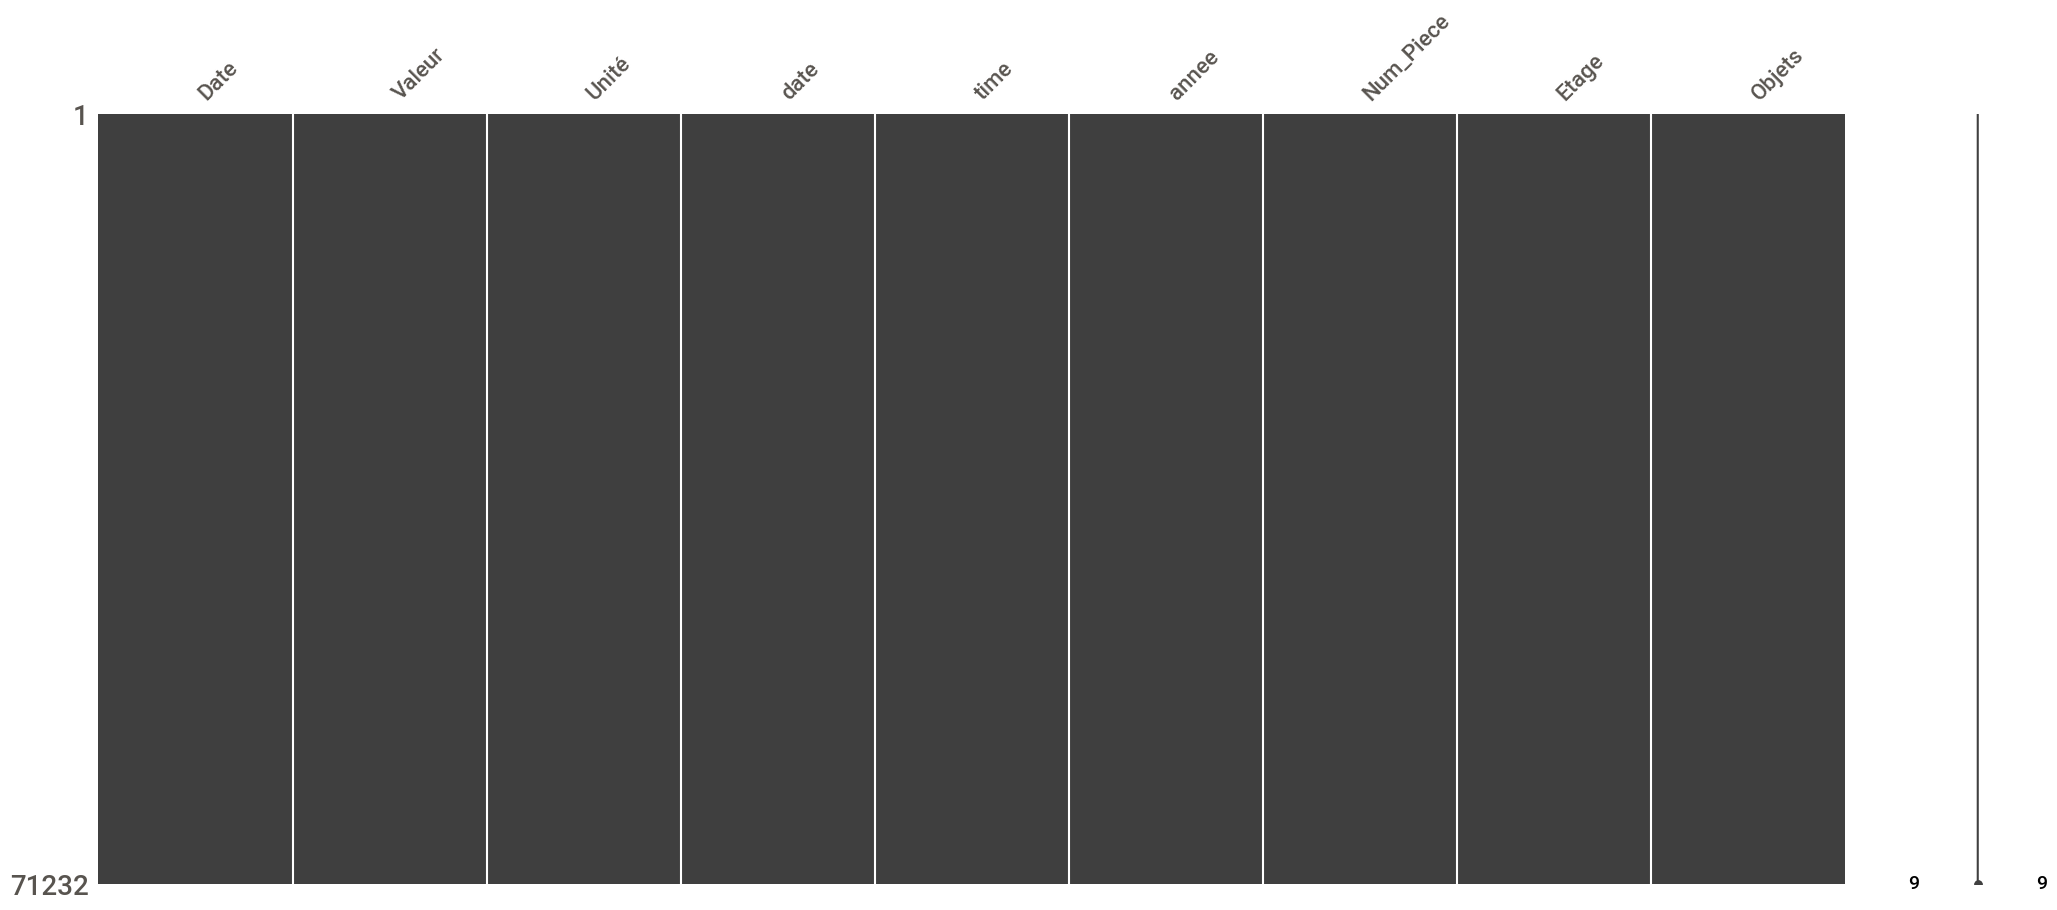

In [102]:
msno.matrix(Tours_Habitat)

In [103]:
# Vérifier les types de données pour validation
print(Tours_Habitat.info())

<class 'pandas.core.frame.DataFrame'>
Index: 71232 entries, 0 to 71239
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       71232 non-null  object        
 1   Valeur     71232 non-null  float64       
 2   Unité      71232 non-null  object        
 3   date       71232 non-null  datetime64[ns]
 4   time       71232 non-null  object        
 5   annee      71232 non-null  object        
 6   Num_Piece  71232 non-null  object        
 7   Etage      71232 non-null  object        
 8   Objets     71232 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 5.4+ MB
None


Rapport des données nettoyées :

In [104]:
my_report = sv.analyze(Tours_Habitat)

                                             |          | [  0%]   00:00 -> (? left)

In [105]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Nouvelle section

Rapport des données de Tours Habitat, binaire entre les Années.

In [107]:
my_report = sv.compare_intra(Tours_Habitat, Tours_Habitat["annee"] == "2024", ["2024", "2023"])

                                             |          | [  0%]   00:00 -> (? left)

In [108]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
